# Natural Language Processing with Disaster Tweets

### Table Of Content
- 1. Introduction
- 2. Loading Dataset
- 3. Examining Basic Properties
- 4. Exploratory Data Analysis (EDA)
    - 4.1. target feature
    - 4.2. location feature
    - 4.3. keyword feature
    - 4.4. text feature
        - 4.4.1. Common Words    
    - 4.5. Feature Extraction
        - 4.5.1. Feature Counts
    - 4.6. Wordclouds
- 5. Data Cleaning
- 6. Building the Model
    - 6.1. Data Preparation
    - 6.2. Encoding the Texts
    - 6.3. Setup GloVe Word Embedding
    - 6.4. Defining the Model
    - 6.5. Training the Model
    - 6.6. Plotting the Model
    - 6.7. All-In-One
    - 6.8. Makeing a Prediction
    - 6.9. Creating a Submission

## 1. Introduction
Welcome, this is my first NLP competition on Kaggle and I've found this competition to be very fit for learning the fundamentals of NLP. Personally, I learned alot from working with the dataset and reading some of the fantastic notebooks. I initially made this notebook for myself, but then decided to add a little bit of content and make it public for anyone interested. So if you like this notebook, don't forget to upvote and comment (:

In [62]:
import re                                                       # Regex
import spacy                                                    # Natural Language Toolkit
import string                                                   # For dealing with strings
import numpy as np                                              # Linear Algebra
import pandas as pd                                             # DataFrame
from wordcloud import WordCloud                                 # Wordclouds
from matplotlib import pyplot as plt                            # Plotting

from keras.layers import Dense, Embedding                       # Keras Layers
from keras.models import Sequential                             # Sequential Model
from keras.utils.vis_utils import plot_model                    # For plotting our model
from keras.preprocessing.text import Tokenizer                  # Keras Tokenizer

nlp = spacy.load('en_core_web_sm')  # Good enough for this dataset, you can also download and use 'en_core_web_md'(~40MB) or 'en_core_web_lg'(~750MB).

## 2. Loading Dataset

In [2]:
# Read datasets
train_df = pd.read_csv('../input/nlp-getting-started/train.csv')
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')

# Combine datasets for ease of use
combined = [train_df, test_df]

train_df.head(5) # Print top 5 rows of training data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 3. Examining Basic Properties
First things first, we explore the very basic properties of our dataset, like how many rows and columns we have and which columns contain NULL values. This helps us get an overall idea of the data we are working with.

In [3]:
# Rows and Columns
print(f'- train_df has {train_df.shape[0]} rows and {train_df.shape[1]} columns: {list(train_df.columns)}')
print(f'- test_df has {test_df.shape[0]} rows and {test_df.shape[1]} columns: {list(test_df.columns)}\n')

- train_df has 7613 rows and 5 columns: ['id', 'keyword', 'location', 'text', 'target']
- test_df has 3263 rows and 4 columns: ['id', 'keyword', 'location', 'text']



In [4]:
# Check NULLs
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Looking at the results, we have *7613* records we can learn from which is not bad! We are going to predict the **target** feature, and our shared columns are: **id, keyword, location and text**.

Now by looking at the NULL counts, we can tell that the **id** is just an indexing (Has no NULL entries, that must be some sort of indexing!) and is probably not something we want to included in our learning features. On the otherhand, the **keyword** feature seems to be important and also doesn't have many NULL entries which is good news! The **location** feature, we can't tell much for now but the **text** seems to be the key feature for our learning process.

## 4. Exploratory Data Analysis (EDA)
Now we know what we have at hand, let's analyze each feature and see how can they be usefull to us, starting from the **target** feature:

### 4.1. "target" feature
What do we know so far? we know this is the feature we are going to be predicting and it's type is *int64*, which is numerical. But if we plot the entries you'll see that there are only 2, meaning this is a **Binary-Classification** problem. So far so good.

It's a good practice to check the distribution of the feature. If our labels aren't equally distributed, the model is likely to become biased towards a specific label (The label with more data). So it's important to keep our categories almost of equal sizes.

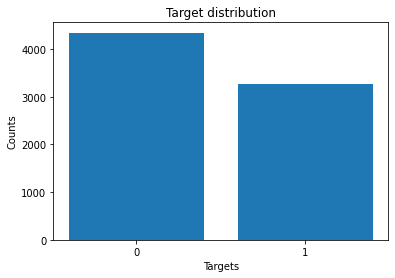

In [5]:
# Check the distribution of tagets
target_counts = train_df['target'].value_counts()

# Plot
plt.title('Target distribution')
plt.xlabel('Targets')
plt.ylabel('Counts')
plt.xticks([0, 1])
plt.bar(target_counts.keys(), target_counts.values)
plt.show()

Looking at the distribution, I say it's OK. It's not evenly balanced and that can be something we have to keep in mind for later optimization. We'll downsample the data and see if it helps. Note that downsampling doesn't always work because we are ignoring a lot of entries to manually balance the data! Another possible approch (Which I'm going to ignore for the sake of keeping it simple) is upsampling that according to [Sweetwater](https://www.sweetwater.com/insync/upsampling/#:~:text=Upsampling%20is%20the%20process%20of,to%20increase%20the%20sampling%20rate.&text=This%20kind%20of%20upsampling%20adds,of%20the%20original%20sampling%20rate.) means:
> Upsampling is the process of inserting zero-valued samples between original samples to increase the sampling rate.

### 4.2. "location" feature

In [6]:
# NULL entries
null_entries = train_df.loc[train_df['location'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "location" column ({round(null_entries_count / train_df.shape[0] * 100, 1)}%)')

- There are 2533 missing entries on "location" column (33.3%)


In [7]:
# Uniqueness
unique_locations = train_df['location'].unique()
unique_locations_count = len(unique_locations)
print(f'- Number of unique locations: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

- Number of unique locations: 3342 (43.9%)


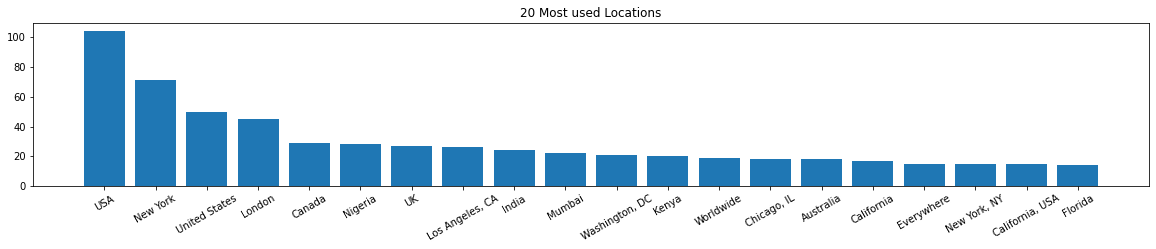

In [8]:
# 20 Top Frequencies
location_freq = train_df['location'].value_counts()
top_20_locs = location_freq[:20]

# Plot
fig = plt.figure(figsize = (20, 3))
plt.title('20 Most used Locations')
plt.bar(top_20_locs.index, top_20_locs.values)
plt.xticks(rotation = 30)
plt.show()

In [9]:
# list(train_df['location'].unique())

What we learn from this analysis:
- One third of our locations are missing.
- Around *44%* of our data is unique, This can be helpful, but hang on.
- After plotting the **20 Most Used Locations** we can see that there are some problems here:
    - Our **location** feature contains cities, states, countries and others.
    - There are some naming issues (for example we have *USA* and *United States*, or we have *New York* and *New York, NY*). If we were to fix these issues the percentage of unique locations will increase.
    - We have some locations like *Worldide* or *Everywhere*. The problem with *Worldwide* is that it doesn't make sense, because it's actually lower than USA (How can that be possible if it is worldwide!)
   

In [10]:
location_freq.index

Index(['USA', 'New York', 'United States', 'London', 'Canada', 'Nigeria', 'UK',
       'Los Angeles, CA', 'India', 'Mumbai',
       ...
       'CA, AZ & NV', 'Deadend, UK', 'us-east-1a', 'Eww, I'm not Paul Elam',
       'Lima-Peru', 'Aberdeenshire', 'twitch.tv/naturalemblem26',
       'Hamilton, ON', ' Little Rock, AR', 'Stanford University'],
      dtype='object', length=3341)

I got concerned over the last problem with the *Worldwide* location, so I printed all the locations and took a look. I found that:
- There are some weird locations like: "**$ad $hawty**"
- There are some typos like: "**New Yor**"
- There are some irrelevant entries as well, like: "**twitch.tv/naturalemblem26**"
- Look what I found, emoji: :**Mexico! ^_^**"
- We got some coordiantes as well: "**-6.152261,106.775995**"

Take a minute to think about our results, Can we rely on the **locations** feature? Nope!

### 4.3. "Keyword" feature
This feature looks promising so far, let's find the 25 most used keywords, percentage of unique values and the number of missing values

In [11]:
# NULL entries
null_entries = train_df.loc[train_df['keyword'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "keyword" column ({round(null_entries_count / train_df.shape[0] * 100, 2)}%)')

- There are 61 missing entries on "keyword" column (0.8%)


In [12]:
# Uniqueness
unique_locations = train_df['keyword'].unique()
unique_locations_count = len(unique_locations)
print(f'- Number of unique keyword: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

- Number of unique keyword: 222 (2.92%)


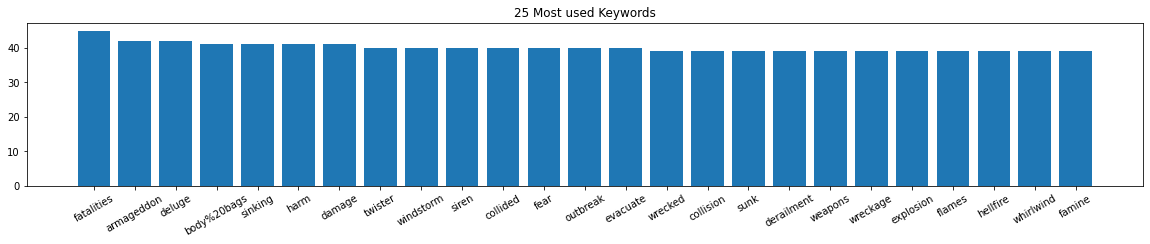

In [13]:
# 20 Top Frequencies
keyword_freq = train_df['keyword'].value_counts()
keys_25_locs = keyword_freq[:25]

# Plot
fig = plt.figure(figsize = (20, 3))
plt.title('25 Most used Keywords')
plt.bar(keys_25_locs.index, keys_25_locs.values)
plt.xticks(rotation = 30)
plt.show()

We can understand from this analysis that:
- There are a few NULL entires for this feature.
- Only 3% of our keywords are unique.
- From the *25 Most used Keywords*, most are related to disasters.
- Spaced bwteen words are represented as %20. (We have to fix that later!)

### 4.4. "Text" feature
Let's first take a look at the texts randomly.

#### Looking Randomly at the Data

In [14]:
# train_df['text'].iloc[:50].values

I found that:
- There are lot's of **#hashtags** used that can be helpful, so extract and store them in a list for each tweet.
- There also are some links, don't know about their usefulness, but I'm going to extract them anyways.
- **@mentions** can be seen in some tweets, maybe they point to a certain user or something, extract the username and store it in a list for each tweet for later analysis.
- There are some emojies and None-ASCII characters that are better be removed.
- Numbers can also be removed as they may be a little misleading.
- Some comments are fully written in uppercase, we may want to make them lowercase.
- There are comments that are almost identical except their links, we can easily detect and remove the duplicates after extracting links (See `train_df['text'].iloc[110:120]`)
- Maybe finding the common words can be useful for identifing which class does each tweet belong to.
- There are some typos in some texts, they can be fixed with some python packages.

#### 4.4.1. Commom Words
Let's get the 39 most common words and see what it looks like.

In [15]:
corpus_counter = dict()

# Initialize the counter
for i, row in train_df.iterrows():
    for word in row['text'].split(' '):
        if word in corpus_counter:
            corpus_counter[word] += 1
        else:
            corpus_counter[word] = 1

# Sort the counter (Descending)
sorted_corpus_counter = sorted(corpus_counter.items(), key = lambda x: x[1])[::-1]

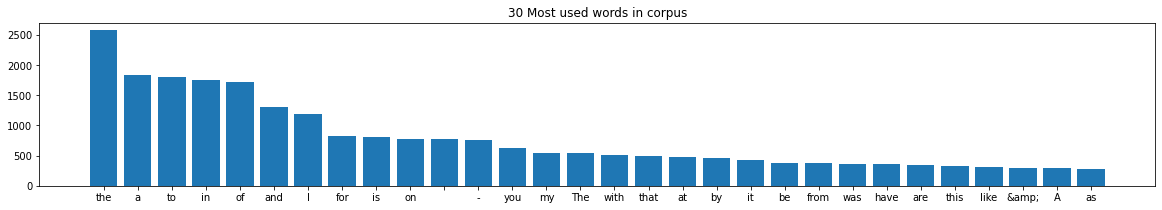

In [16]:
top_30_corpus = sorted_corpus_counter[:30]
top_30_corpus_index = [key for key, value in top_30_corpus]
top_30_corpus_values = [value for key, value in top_30_corpus]

# Plot
fig = plt.figure(figsize = (20, 3))
plt.title('30 Most used words in corpus')
plt.bar(top_30_corpus_index, top_30_corpus_values)
plt.show()

Looking at the 30 top words in the corpus, we figure:
- There are lot's of stopwords and punctuations we might want to get rid of.

### 4.5. Feature Extraction
We extract linkes, **#hashtags** and **@mentions** from the tweet texts and store them in the dataset as lists. By a more careful analysis, notice that links have been shortened. You could scrape each link and search for topics and healines but since this is time consuming and there aren't many links in the dataset, I decided to use a more simple approach and remove them all.

I also found **@mentions** useless as they are usernames and usernames can be pretty meaningless and made of random characters. Let's not over-complicate the analysis and remove them as well; But **#hashtags** are still useful in some ways.

In [17]:
def extract_hashtag(text):
    matches = re.findall(r'#\w*', text)
    return [match[1:].lower() for match in matches] if matches != [] else None

def extract_mention(text):
    matches = re.findall(r'@\w*', text)
    return [match[1:].lower() for match in matches] if matches != [] else None

def extract_links(text):
    matches = re.findall(r'\bhttps?://\S+', text)
    return matches if matches != [] else None

In [18]:
# Create two new features for #hashtags, @mentions and links
for df in combined:
    df['hashtags'] = df['text'].apply(extract_hashtag)
    df['mentions'] = df['text'].apply(extract_mention)
    df['links'] = df['text'].apply(extract_links)

#### 4.5.1. Feature Counts

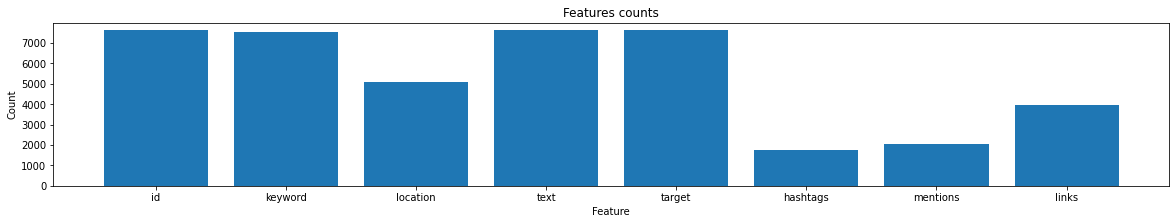

In [19]:
feature_counts = train_df.count()

# Plot
fig = plt.figure(figsize = (20, 3))
plt.title('Features counts')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.bar(feature_counts.keys(), feature_counts.values)
plt.show()

As you can see, many mentions and links are missing already and can't be much of a help. That brings us almost to our first place, with only the **hashtags** feature to work with. But that's ok because that was necessary to get us to the point where we can be confident in our decisions about ignoring the rest of them when training the model.

### 4.6. WordClouds

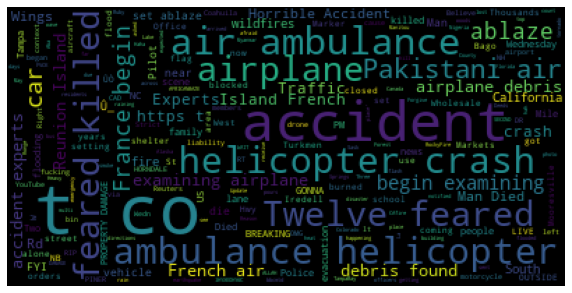

In [20]:
# Word cloud for disaster tweets
disaster_word_cloud = WordCloud(max_font_size = 50)
disaster_word_cloud.generate(" ".join(train_df.loc[train_df['target'] == 1, 'text'].iloc[:100]))

# Plot
plt.figure(figsize = (10, 8))
plt.imshow(disaster_word_cloud)
plt.axis('off')
plt.show()

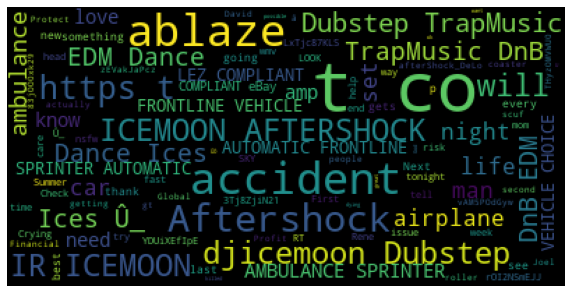

In [21]:
# Word cloud for non-disaster tweets
normal_word_cloud = WordCloud(max_font_size = 50)
normal_word_cloud.generate(" ".join(train_df.loc[train_df['target'] == 0, 'text'].iloc[:100]))

# Plot
plt.figure(figsize = (10, 8))
plt.imshow(normal_word_cloud)
plt.axis('off')
plt.show()

## 5. Data Cleaning
Let's start cleaning our text data. My approch is not very optimal as I am iterating through each tweet text multiple times, but it's easier to experiment with (It's more dynamic). Different models require different cleaning processes so try experimenting with the cleaning functions.

In [22]:
# Remove URLs
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# Remove HTML
def remove_html(text):
    return re.sub(r'<.*?>', '', text)

# Converts text to lowercase
def to_lower(text):
    return text.lower()

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Remove mentions
def remove_mentions(text):
    return re.sub(r'@\w*', '', text)

# Remove emojis
def remove_emojis(text):
    regrex_pattern = re.compile(pattern = "["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)

# Remove non-ASCII characters
def remove_non_ascii(text):
    return ''.join(filter(lambda x: x in string.printable, text))

# Lemmatize text
def lemmatize_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

# Remove stopwords
def remove_stopwords(text):
    return ' '.join([token.text for token in nlp(text) if not token.is_stop])

# Remove punctuation
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove white space (Extra step, just in case)
def remove_whitespace(text):
    return ' '.join(text.split())

# Filter words
def filter_words(text, min_len = 2):
    return ' '.join([word for word in text.split(' ') if len(word) > min_len])

In [23]:
def clean_text(text):
    ''' Properties to remove when cleaning the given text'''      

    # Convert to Lowercase
    text = to_lower(text)

    # Remove URLs
    text = remove_urls(text)
    
    # Remove HTML
    text = remove_html(text)   
    
    # Remove Numbers
    text = remove_numbers(text)
    
    # Remove @mentions
    text = remove_mentions(text)
    
    # Remove Emojis
    text = remove_emojis(text)
    
    # Remove Non-ASCII characters
    text = remove_non_ascii(text)
    
    # Remove Punctuations
    text = remove_punctuation(text)
    
    # Remove Stopwords
    text = remove_stopwords(text)

    # Lemmatize
    text = lemmatize_text(text)

    # Remove Stopwords (Repeat)
    text = remove_stopwords(text)    
    
    # Remove short words
    text = filter_words(text)
    
    # Remove WhiteSpaces
    text = remove_whitespace(text)

    return text

In [24]:
# Clean text
for i, df in enumerate(combined):
    df['cleaned_text'] = df['text'].apply(clean_text)    
    print(f'Cleaning & filtering completed for the {i + 1}th dataset.')

train_df.head()

Cleaning & filtering completed for the 1th dataset.
Cleaning & filtering completed for the 2th dataset.


,id,keyword,location,text,target,hashtags,mentions,links,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],None,None,deeds reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,None,None,None,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,None,None,None,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],None,None,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]",None,None,send photo ruby alaska smoke wildfire pour school


## Build the Vocabulary

vocab

## 6. Building the Model

### 6.1 Data Preperation

In [25]:
# Shuffle training data to make sure there are no unwanted patterns
train_df = train_df.sample(frac = 1).reset_index(drop = True)

train_df.head()

,id,keyword,location,text,target,hashtags,mentions,links,cleaned_text
0,2587,crash,NaN,??One night and we're gonna come and crash the...,0,None,None,[https://t.co/9hKXxBB82O],night gon na come crash party nt invite feelin
1,4415,electrocute,NaN,Electric vs Gas brewing (not wanting to electr...,0,None,None,[http://t.co/26oo0fcL53],electric vs gas brewing want electrocute question
2,4406,electrocute,#otrakansascity,I wanna tweet a 'niall thx for not making me w...,0,None,None,None,wanna tweet niall thx electrocute tweet scare ...
3,4143,drought,"Abuja,Nigeria",'California's Burning:' Gov. on Drought Wildfi...,1,None,None,[http://t.co/mkqSVp8E0G],californias burn gov drought wildfire
4,1604,bombed,Atlanta Georgia,@WhiteHouse @POTUS Just cos Germany invaded Po...,1,None,"[whitehouse, potus]",[http://t.co/I2AAG6Lp6W],cos germany invade poland japan bomb pearl har...


### 6.2. Encoding the Texts

In [53]:
# Define tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Build vocabulary
word_index = tokenizer.word_index

# Modes: 'binary', 'count', 'freq', 'tfidf'
train_encoding = tokenizer.texts_to_matrix(train_df['cleaned_text'], mode = 'count')
test_encoding = tokenizer.texts_to_matrix(test_df['cleaned_text'], mode = 'count')

# Print Encoding shapes
print('Train Encoding shape:', train_encoding.shape)
print('Test Encoding shape:', test_encoding.shape)

Train Encoding shape: (7613, 12583)
Test Encoding shape: (3263, 12583)


### 6.3. Setup GloVe Word Embedding

In [54]:
# compute an index mapping words to known embeddings
embeddings_index = {}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt') as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype = 'float32')

# computer matrix for the vocabulary words
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector    # words not found in embedding index will be all-zeros.

### 6.3. Defining the Model

In [68]:
def build_model(x, loss, optimizer, metrics):
    model = Sequential()
    
    # Embedding Layer
    model.add(Embedding(
        input_dim = len(word_index) + 1,            # Vicabulary size
        output_dim = 100,
        weights = [embedding_matrix],               # GloVe weights
        input_length = train_encoding.shape[1],     # Sequence length
        trainable = False
    ))
    
    # Dense Layers
    model.add(Dense(units = 64, input_shape = (x.shape[1],), activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(loss = loss, optimizer = optimizer, metrics = metrics)  

    return model

### 6.4. Training the Model

In [74]:
def train_model(model, x, y, epochs, batch_size, validation_split):
    history = model.fit(
        x = x,
        y = y,
        epochs = epochs,
        batch_size = batch_size,
        validation_split = validation_split,
        verbose = 1
    )

    return history.history

### 6.5. Plotting the Model

In [70]:
def plot_model_training(epochs, history, metrics):    

    def plot_subplot(axs, metric, val_metric):
        ''' Plot a single subplot '''

        axs.set_title('Analysis of ' + metric)
        axs.plot(epochs, history[metric], label = metric)
        axs.plot(epochs, history[val_metric], label = val_metric)
        axs.legend()

    fig, axs = plt.subplots(1, len(metrics), figsize = (18, 5))

    for i, metric in enumerate(metrics):
        plot_subplot(axs[i], metric, 'val_' + metric)

### 6.6. All-In-One

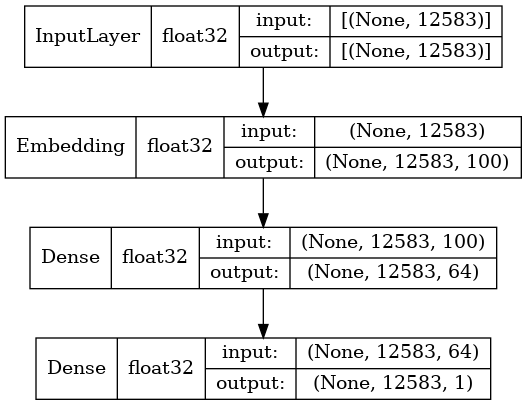

In [71]:
# Change variable names to convention
X_train = train_encoding
y_train = train_df['target']

# Build model
model = build_model(
  x = X_train,
  loss = 'binary_crossentropy',
  optimizer = 'adam',
  metrics = ['accuracy']
)

# Plot model
plot_model(model = model, show_dtype = True, show_shapes = True, show_layer_names = False)

In [ ]:
# Train model
history = train_model(
  model = model,
  x = X_train,
  y = y_train,
  epochs = 10,
  batch_size = 64,
  validation_split = 0.2
)

# Plot training process
epochs = [i for i in range(len(history['loss']))]
plot_model_training(
  epochs = epochs,
  history = history,
  metrics = ['accuracy', 'loss']
)

Epoch 1/10
96/96 [==============================] - 62s 647ms/step - loss: 0.6878 - accuracy: 0.5685 - val_loss: 0.6855 - val_accuracy: 0.5778
Epoch 2/10
96/96 [==============================] - 62s 647ms/step - loss: 0.6858 - accuracy: 0.5685 - val_loss: 0.6831 - val_accuracy: 0.5778
Epoch 3/10
96/96 [==============================] - 62s 643ms/step - loss: 0.6844 - accuracy: 0.5685 - val_loss: 0.6818 - val_accuracy: 0.5778
Epoch 4/10
51/96 [==============>...............] - ETA: 26s - loss: 0.6821 - accuracy: 0.5760

### 6.7. Make a Prediction

In [ ]:
X_test = test_encoding

pred = model.predict(X_test, verbose = 2)
pred = np.round(pred).astype(int).reshape(pred.shape[0])

### 6.8. Create submission

In [ ]:
submission = pd.DataFrame({'id': test_df['id'].values.tolist(), 'target': pred})
submission.to_csv('./submission.csv', index = False)